# Laboratorio 2 - Series de tiempo
## Consumo de combustible

##### Sebastian Aristondo 20880
##### Daniel Gonzalez 20293

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from pmdarima import auto_arima

## 1. Análisis expolatorio

In [60]:
import warnings

# Filter out all warnings
warnings.filterwarnings("ignore")

### 1.1 Consumo de combustibles

In [23]:
consumo = pd.read_csv('Importacion.csv', sep=',')
consumo.head()

,Fecha,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,...,Naftas,Petcoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,MTBE,Orimulsión,Petróleo reconstituido,Total importación
0,Jan/2001,0.00,"27,748.99","214,581.84",0.0,0.00,0.00,0.00,"194,065.74",820.00,...,0.0,0.00,0.00,0.00,0.0,"566,101.99","8,402.00",0.00,"715,344.00","2,312,639.05"
1,Feb/2001,0.00,"7,503.57","294,609.00",0.0,0.00,0.00,0.00,"170,703.38","3,054.00",...,0.0,0.00,0.00,0.00,0.0,"489,525.80",0.00,0.00,"370,166.00","1,769,208.76"
2,Mar/2001,0.00,"26,304.32","315,263.80",0.0,0.00,0.00,0.00,"161,837.37",677.00,...,0.0,0.00,0.00,0.00,0.0,"575,559.68",0.00,0.00,"360,530.00","1,945,770.26"
3,Apr/2001,0.00,"7,885.89","205,653.00",0.0,0.00,0.00,0.00,"163,048.64","3,399.00",...,0.0,0.00,0.00,0.00,0.0,"437,745.42","8,184.00",0.00,"359,527.00","1,623,637.76"
4,May/2001,0.00,"8,443.16","278,371.30",0.0,0.00,0.00,0.00,"171,518.86",585.00,...,0.0,0.00,0.00,0.00,0.0,"552,609.13","12,680.00",0.00,"723,346.00","2,262,726.64"


In [24]:
columns_to_convert = [col for col in consumo.columns if col != 'Fecha']
consumo[columns_to_convert] = consumo[columns_to_convert].apply(lambda x: x.str.replace(',', '').astype(float) if x.dtype == 'object' else x)\

consumo.describe()

,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petróleo,Gasolina de aviación,Gasolina regular,...,Naftas,Petcoke,Petróleo crudo,Solventes,Butano,Diesel alto azufre,MTBE,Orimulsión,Petróleo reconstituido,Total importación
count,269.000000,269.000000,2.690000e+02,268.000000,269.000000,2.690000e+02,269.000000,269.000000,269.000000,269.000000,...,269.000000,269.000000,269.000000,269.000000,269.000000,2.690000e+02,269.000000,269.000000,269.000000,2.690000e+02
mean,4925.849219,8377.068104,2.932919e+05,66.469142,23354.625985,2.707193e+05,2644.297993,399026.255836,2190.599963,381883.121301,...,18.012156,130957.898885,85.037807,1982.305428,11.127658,5.932604e+05,529.620818,15245.725465,36383.646840,2.683717e+06
std,10361.422607,15540.817619,1.732186e+05,169.789987,39079.450100,4.923333e+05,8639.971237,190173.418711,4759.553019,219364.354885,...,75.623403,177782.481823,402.932935,4805.774497,31.826152,3.955986e+05,2656.125757,67947.077221,136858.023974,7.282181e+05
min,0.000000,0.000000,8.484760e+03,0.000000,0.000000,0.000000e+00,0.000000,100561.470000,0.000000,81015.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.381787e+06
25%,0.000000,2746.310000,1.561090e+05,0.000000,0.000000,0.000000e+00,0.000000,218257.510000,0.000000,201907.670000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.219529e+05,0.000000,0.000000,0.000000,2.096132e+06
50%,0.000000,5405.190000,2.804147e+05,0.000000,0.000000,0.000000e+00,0.000000,396363.050000,381.000000,305285.530000,...,0.000000,137087.500000,0.000000,0.000000,0.000000,6.836644e+05,0.000000,0.000000,0.000000,2.570638e+06
75%,0.000000,9947.000000,4.072329e+05,0.000000,44504.810000,0.000000e+00,0.000000,540671.880000,2651.000000,528347.810000,...,0.000000,167480.500000,0.000000,0.000000,0.000000,8.508069e+05,0.000000,0.000000,0.000000,3.168497e+06
max,46934.140000,171826.960000,1.051764e+06,920.120000,158719.360000,1.592580e+06,48945.910000,960840.530000,27979.070000,987872.050000,...,513.830000,882244.120000,4115.910000,24501.430000,149.090000,1.595699e+06,19431.000000,344685.000000,730957.000000,4.850360e+06


In [25]:
consumo['Fecha'] = pd.to_datetime(consumo['Fecha'], format='%b/%Y')
consumo.dtypes

Fecha                       datetime64[ns]
Aceites lubricantes                float64
Asfalto                            float64
Bunker                             float64
Ceras                              float64
Combustible turbo jet              float64
Diesel bajo azufre                 float64
Diesel ultra bajo azufre           float64
Gas licuado de petróleo            float64
Gasolina de aviación               float64
Gasolina regular                   float64
Gasolina superior                  float64
Grasas lubricantes                 float64
Kerosina                           float64
Mezclas oleosas                    float64
Naftas                             float64
Petcoke                            float64
Petróleo crudo                     float64
Solventes                          float64
Butano                             float64
Diesel alto azufre                 float64
MTBE                               float64
Orimulsión                         float64
Petróleo re

In [26]:
nans_por_columna = consumo.isna().sum()

print("Valores NaN por columna:")
print(nans_por_columna)

Valores NaN por columna:
Fecha                       0
Aceites lubricantes         0
Asfalto                     0
Bunker                      0
Ceras                       1
Combustible turbo jet       0
Diesel bajo azufre          0
Diesel ultra bajo azufre    0
Gas licuado de petróleo     0
Gasolina de aviación        0
Gasolina regular            0
Gasolina superior           0
Grasas lubricantes          0
Kerosina                    0
Mezclas oleosas             0
Naftas                      0
Petcoke                     0
Petróleo crudo              0
Solventes                   0
Butano                      0
Diesel alto azufre          0
MTBE                        0
Orimulsión                  0
Petróleo reconstituido      0
Total importación           0
dtype: int64


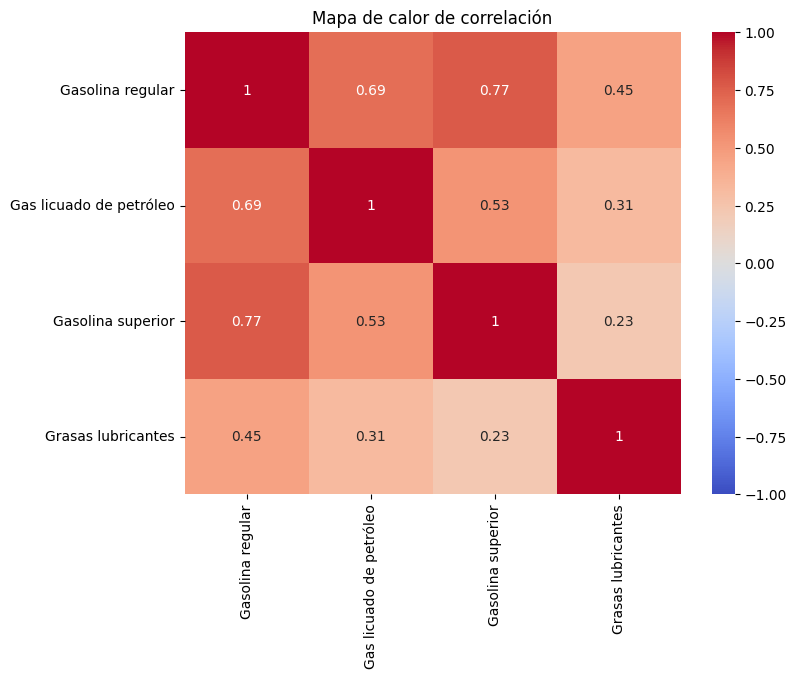

In [27]:
columnas_interes = ["Gasolina regular", "Gas licuado de petróleo", "Gasolina superior","Grasas lubricantes"]
consumo_numericas = consumo[columnas_interes]

correlation_matrix = consumo_numericas.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Mapa de calor de correlación')
plt.show()

c:\Users\Daniel\Main\UVG\Semestre VIII\Data science\Lab2_DS\myenv\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


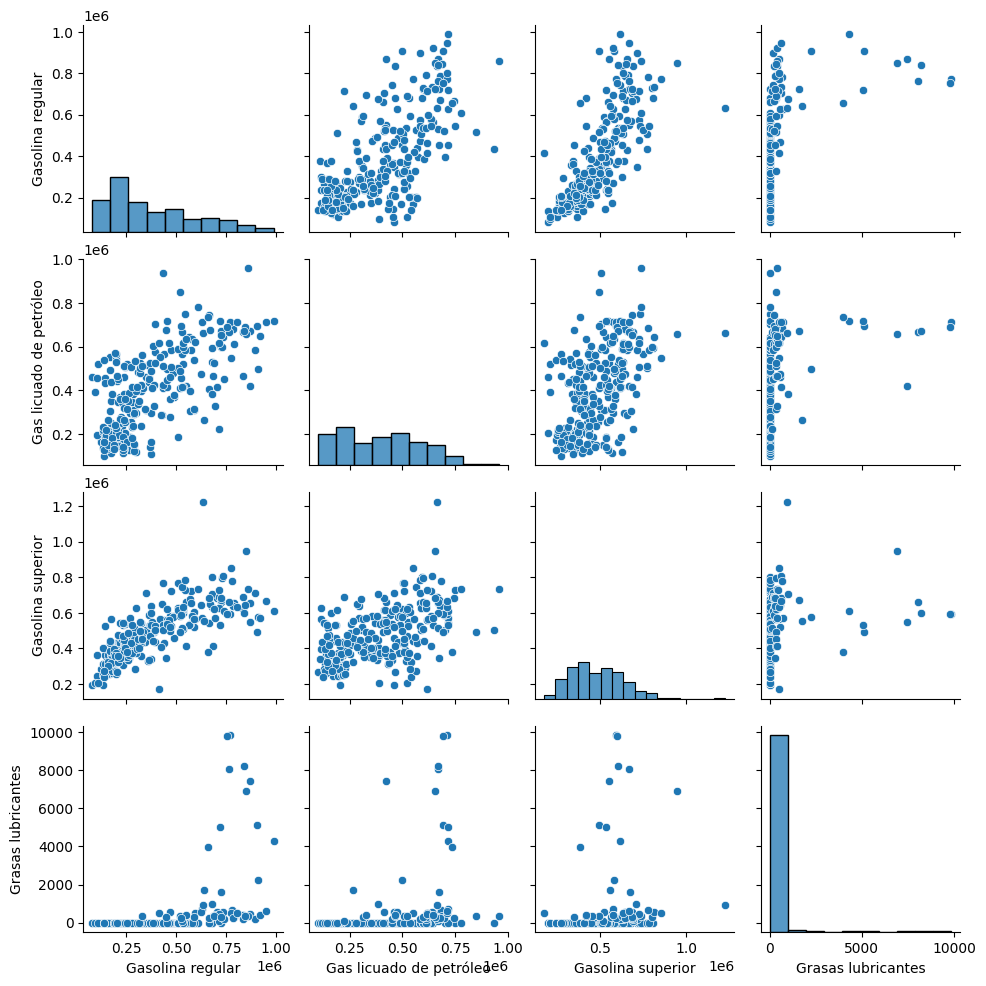

In [28]:
grid = sns.pairplot(consumo_numericas)
plt.show()

In [29]:
normality_test = consumo_numericas.apply(normaltest)
print("Resultados de test de normalidad: \n", normality_test)

Resultados de test de normalidad: 
    Gasolina regular  Gas licuado de petróleo  Gasolina superior  \
0         26.731272                25.680181          27.221501   
1          0.000002                 0.000003           0.000001   

   Grasas lubricantes  
0        3.130772e+02  
1        1.037865e-68  


Ninguna de las distribuciones de las variables interesantes es normal.

In [30]:
consumo["Mes"] = consumo["Fecha"].dt.month
consumo["Año"] = consumo["Fecha"].dt.year

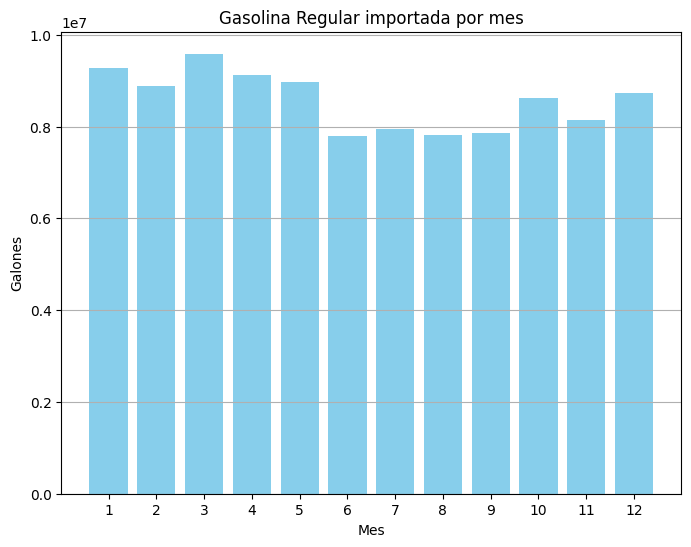

In [31]:
suma_por_mes = consumo.groupby('Mes')['Gasolina regular'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina Regular importada por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

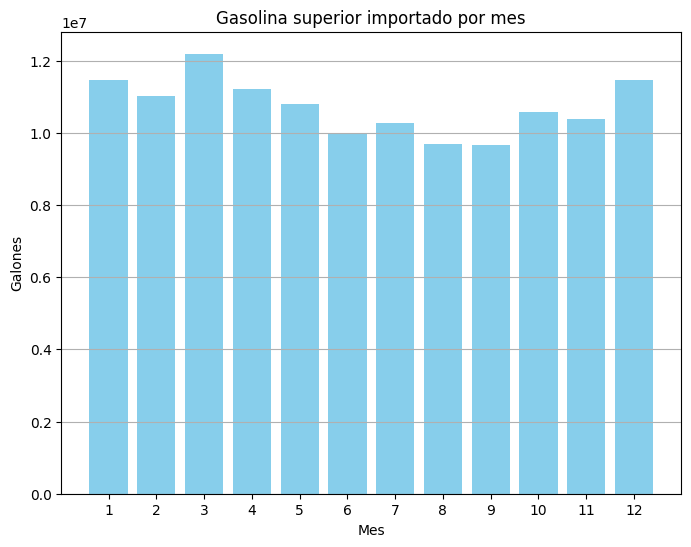

In [32]:
suma_por_mes = consumo.groupby('Mes')['Gasolina superior'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina superior importado por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

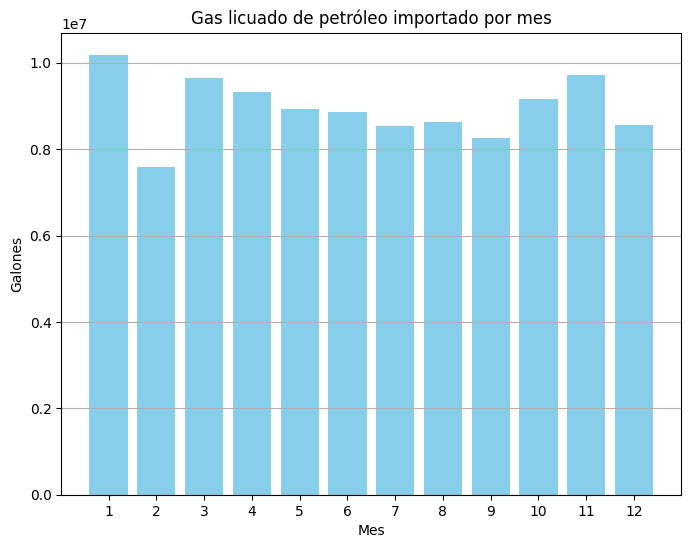

In [33]:
suma_por_mes = consumo.groupby('Mes')['Gas licuado de petróleo'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gas licuado de petróleo importado por mes')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

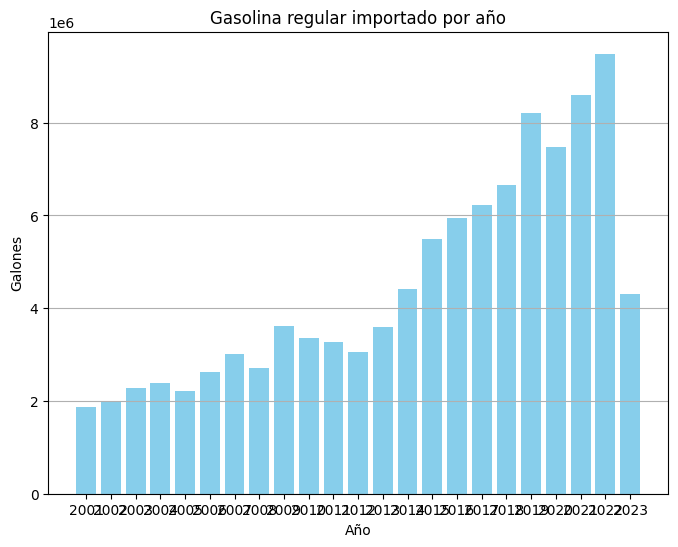

In [34]:
suma_por_mes = consumo.groupby('Año')['Gasolina regular'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gasolina regular importado por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

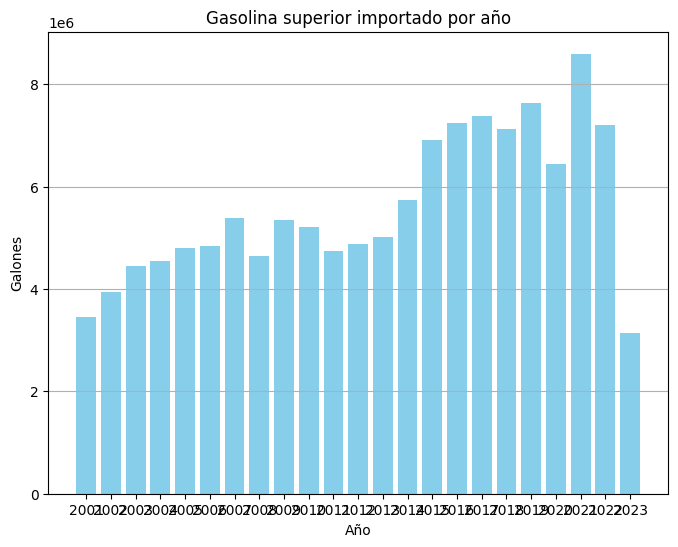

In [35]:
suma_por_mes = consumo.groupby('Año')['Gasolina superior'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gasolina superior importado por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

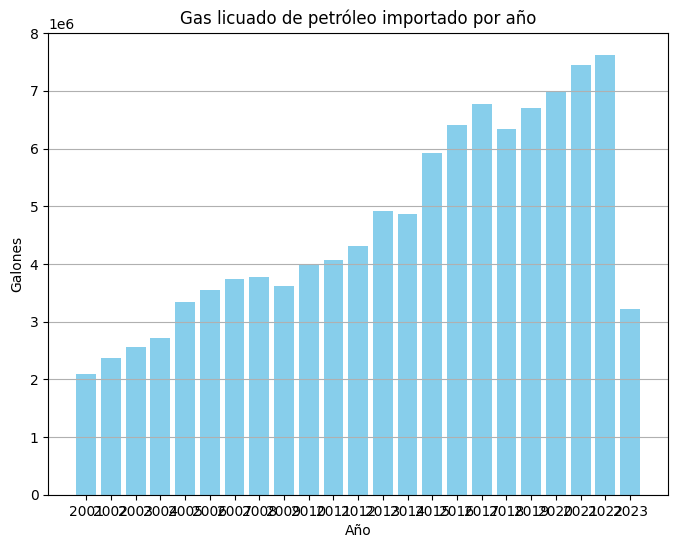

In [36]:
suma_por_mes = consumo.groupby('Año')['Gas licuado de petróleo'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Año'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Año')
plt.ylabel('Galones')
plt.title('Gas licuado de petróleo importado por año')
plt.xticks(suma_por_mes['Año'])
plt.grid(axis='y')
plt.show()

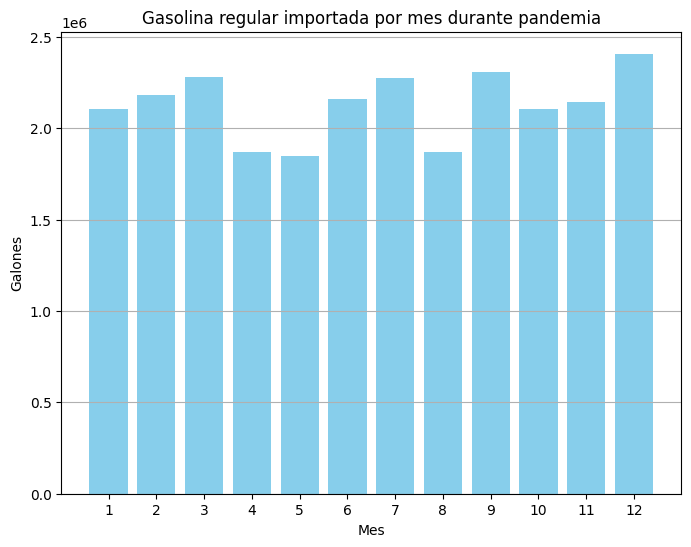

In [37]:
datos_pandemia = consumo[(consumo["Fecha"].dt.year >= 2020) & (consumo["Fecha"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Gasolina regular'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina regular importada por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

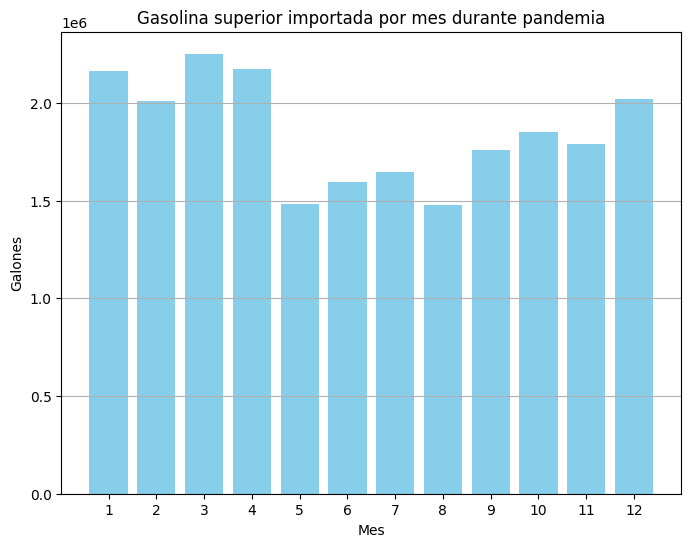

In [38]:
# datos_pandemia = consumo[(consumo["Fecha"].dt.year >= 2020) & (consumo["Fecha"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Gasolina superior'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gasolina superior importada por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

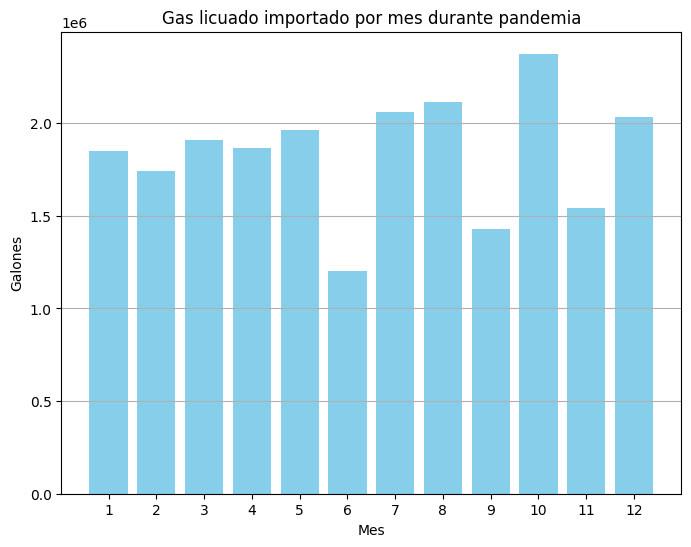

In [39]:
# datos_pandemia = consumo[(consumo["Fecha"].dt.year >= 2020) & (consumo["Fecha"].dt.year <= 2022)]
suma_por_mes = datos_pandemia.groupby('Mes')['Gas licuado de petróleo'].sum().reset_index(name='Suma')

# Graficar la suma por mes usando matplotlib
plt.figure(figsize=(8, 6))
plt.bar(suma_por_mes['Mes'], suma_por_mes['Suma'], color='skyblue')
plt.xlabel('Mes')
plt.ylabel('Galones')
plt.title('Gas licuado importado por mes durante pandemia')
plt.xticks(suma_por_mes['Mes'])
plt.grid(axis='y')
plt.show()

## 2. Elección de series de tiempo   **AQUI**

* Serie 1: Consumo de diesel
* Serie 2: Importacion de gasolina regular
* Serie 3: Precio de gasolina super

## 3. Análisis de series de tiempo - Consumo de diesel

#### a. Especifique Inicio, fin, y frecuencia.

In [40]:
print("Inicio de frecuencia: ", min(consumo["Fecha"]))
print("Fin de frecuencia: ", max(consumo["Fecha"]))
print("La frecuencia es mensual")

Inicio de frecuencia:  2001-01-01 00:00:00
Fin de frecuencia:  2023-05-01 00:00:00
La frecuencia es mensual


#### b. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

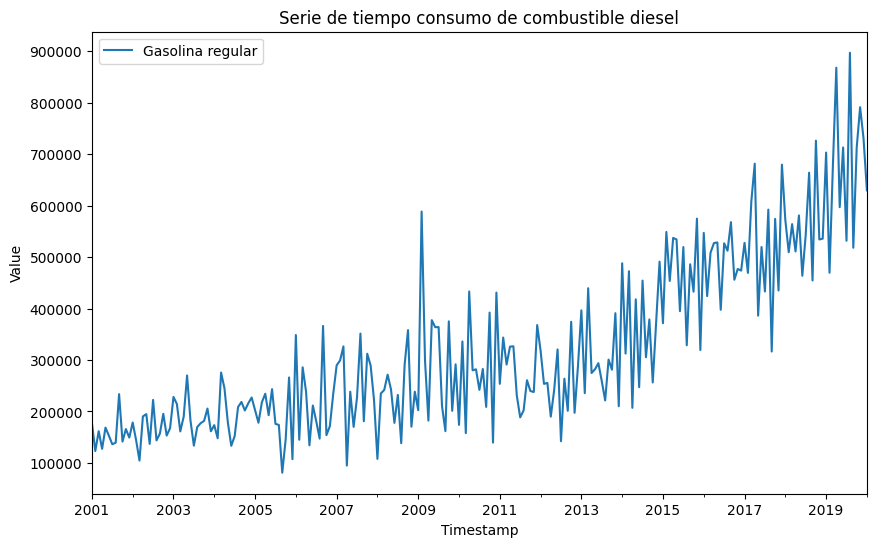

In [42]:
importacion_regular = consumo[["Fecha", "Gasolina regular"]].copy()
importacion_regular["Fecha"] = pd.to_datetime(importacion_regular["Fecha"])
importacion_regular.set_index("Fecha", inplace=True)

importacion_regular_train = importacion_regular[importacion_regular.index <= "2020-01-01"].copy()
importacion_regular_test = importacion_regular[importacion_regular.index > "2020-01-01"].copy()


# importacion_regular_train = importacion_regular_train[importacion_regular_train["Fecha"].dt.year >= 2020]
# importacion_regular_train["Fecha"] = pd.to_datetime(importacion_regular_train["Fecha"])
# importacion_regular_train.set_index("Fecha" , inplace=True)

# importacion_regular_test["Fecha"] = pd.to_datetime(importacion_regular_test["Fecha"])
# importacion_regular_test.set_index("Fecha", inplace=True)

importacion_regular_train.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo consumo de combustible diesel')
plt.show()

A primera vista se puede observar que existe una tendencia a la alza en la serie de tiempo de importación de gasolina regular. No parece haber estacionalidad en media. Además, existen variaciones en la varianza, por lo que tampoco parece ser estacionaria en varianza.

#### c. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

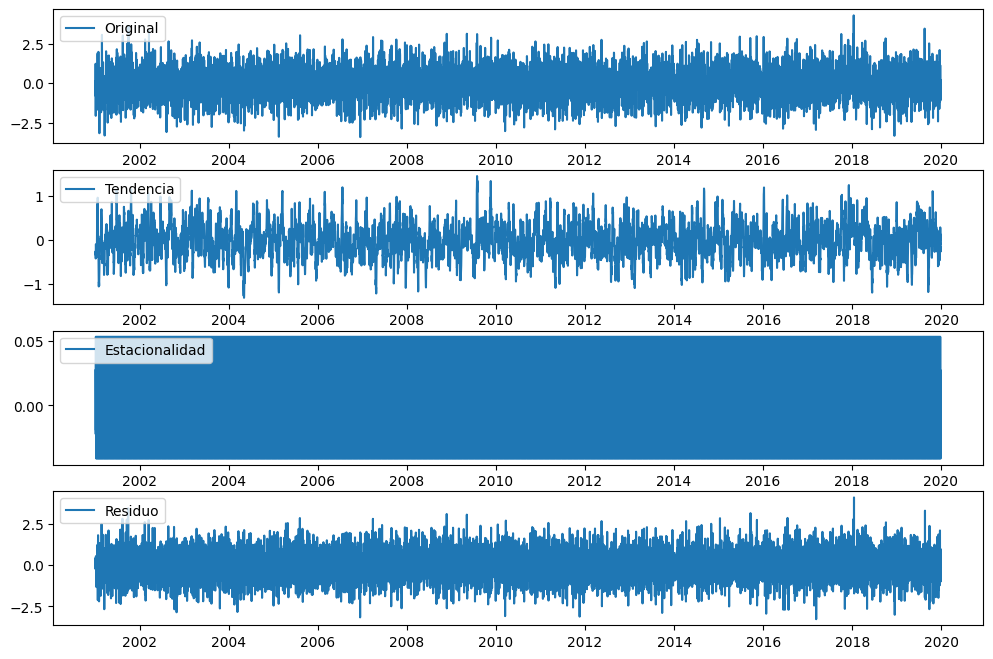

In [43]:
# Crear un índice de fechas para la serie temporal (puedes omitir esta parte si ya tienes un DataFrame con fechas como índice)
date_rng = pd.date_range(start=min(importacion_regular_train.index), end=max(importacion_regular_train.index), freq='D')
values = np.random.randn(len(date_rng))  # Valores aleatorios para el ejemplo

# Crear el DataFrame con la serie temporal
ts_df = pd.DataFrame(values, index=date_rng, columns=['Value'])

# Realizar la descomposición
result = seasonal_decompose(ts_df['Value'], model='additive', period=7)  # Puedes cambiar 'additive' a 'multiplicative' según la naturaleza de la estacionalidad

# Visualizar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(ts_df['Value'], label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residuo')
plt.legend(loc='upper left')
plt.show()

Al graficar la serie de tiempo para la importación de gasolina regular en Guatemala, se puede observar que existe una tendencia a la alza. Esto puede indicar que no existe estacionariedad en media. También se observa que la varianza no es constante, por lo que igualmente es posible que no exista estacionariedad en varianza. No se puede observar por la cantidad de datos, pero es posible que exista estacionalidad. Se realizará la prueba de Dickey Fuller para confirmar si existe estacionariedad en media.

#### d. Determine si es necesario transformar la serie. Explique.

Se aplicará logaritmo a la serie para poder hacerla estacionaria en varianza. Como se mencionó, se puede observar en la serie de tiempo diferencias entre las varianzas.

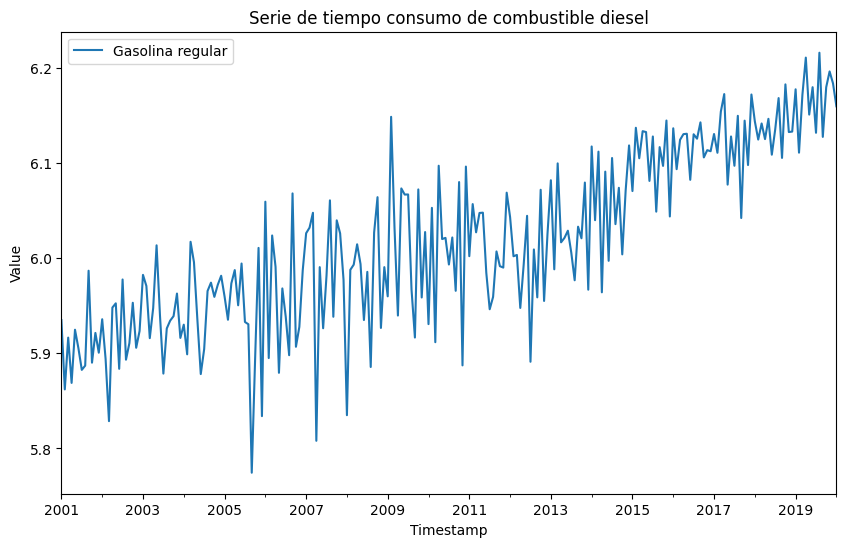

In [47]:
transformed_values, lambda_value = boxcox(importacion_regular_train['Gasolina regular'])
# transformed_values = np.log(importacion_regular_train['Gasolina regular'])
importacion_regular_train1 = importacion_regular_train.copy()
importacion_regular_train1['Gasolina regular'] = transformed_values
importacion_regular_train1.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo consumo de combustible diesel')
plt.show()


#### d. Explique si no es estacionaria en media. Para esto:

##### i. Haga el gráfico de autocorrelación y úselo para explicar la no estacionariedad en media.

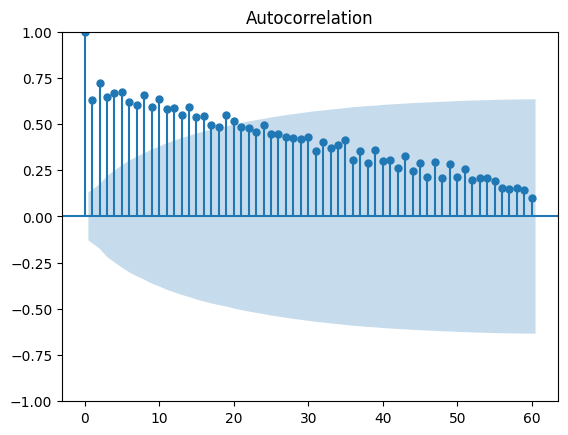

In [48]:
fig = plot_acf(importacion_regular_train1['Gasolina regular'], lags=60)
plt.show()

Se puede observar en la autocorrelación que no se llega a 0 rápidamente. Esto puede indicar una correlación entre diferentes períodos, lo cual indica que no hay estacionaridad en la serie de tiempo.

##### ii. Básese en los valores de estadísticos como la prueba de Dickey-Fuller Aumentada para corroborar la no estacionariedad en media. ¿Qué es necesario hacer para hacerla estacionaria en media en caso de que no lo sea?

In [49]:
def check_stationarity(timeseries):
    # Realizar la prueba ADF
    resultado_adf = adfuller(timeseries)

    # Extraer los resultados importantes de la prueba
    adf_stat = resultado_adf[0]
    p_valor = resultado_adf[1]
    valores_criticos = resultado_adf[4]

    # Imprimir los resultados
    print("Estadístico ADF:", adf_stat)
    print("P-valor:", p_valor)
    print("Valores críticos:")
    for key, value in valores_criticos.items():
        print(f"  {key}: {value}")
check_stationarity(importacion_regular_train1)

Estadístico ADF: 0.35097889997610626
P-valor: 0.9795662114853186
Valores críticos:
  1%: -3.461136478222043
  5%: -2.875078880098608
  10%: -2.5739861168199027


Por medio de ADF se puede observar que la serie no es estacionaria, al tener un p-value de 0.98, entonces no se puede rechazar la hipótesis nula, por lo que se procede a diferenciarla.

In [50]:
importacion_regular_train1 = importacion_regular_train1.diff().dropna()
check_stationarity(importacion_regular_train1)

Estadístico ADF: -7.115130385291561
P-valor: 3.848468024728623e-10
Valores críticos:
  1%: -3.461136478222043
  5%: -2.875078880098608
  10%: -2.5739861168199027


Una vez se realizó una diferenciación, se volvió a realizar el test ADF y se logró determinar que ahora la serie de tiempo es estacionaria, al obtener un valor menor a la significancia.

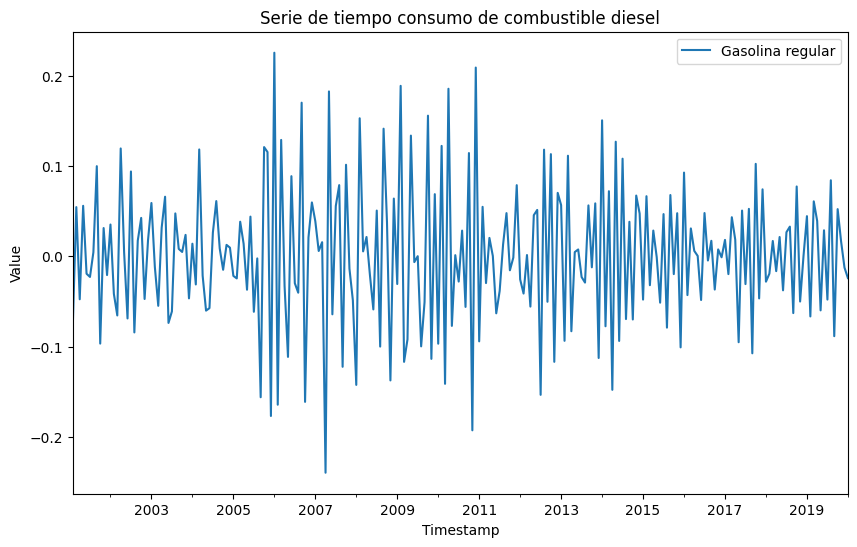

In [51]:
importacion_regular_train1.plot(figsize=(10, 6))
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Serie de tiempo consumo de combustible diesel')
plt.show()

En el gráfico no se puede observar una tendencia, si no que parece ser que la media es constante.

#### f. Una vez analizada la serie, elija los parámetros p, q y d del modelo ARMA o ARIMA que utilizará para predecir. Explique en qué se basó para darle valor a estos parámetros, basándose en las funciones de autocorrelación y autocorrelación parcial. Si usa la función autoarima de R, determine y explique si tiene sentido el modelo propuesto.

### Autocorrelación parcial

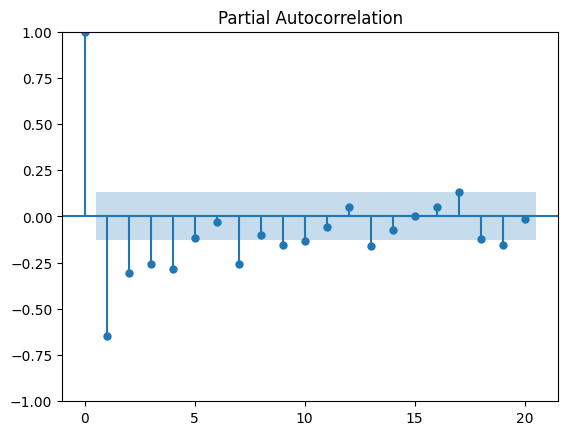

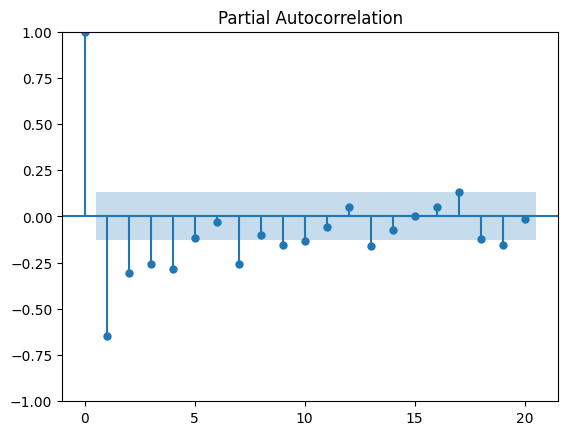

In [132]:
plot_pacf(importacion_regular_train1, lags=20)

### Autocorrelación

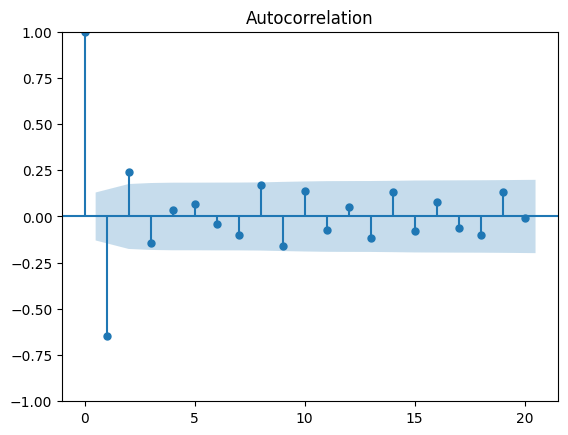

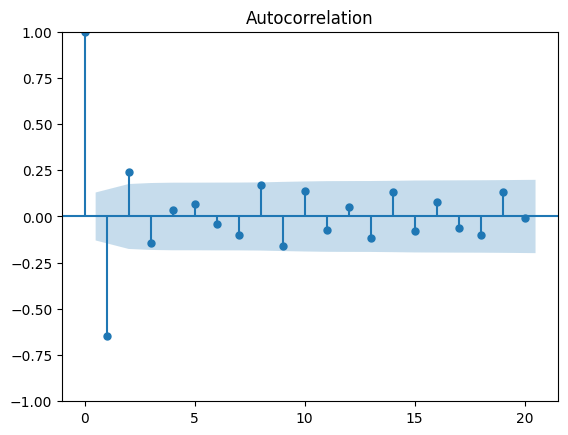

In [130]:
plot_acf(importacion_regular_train1, lags=20)

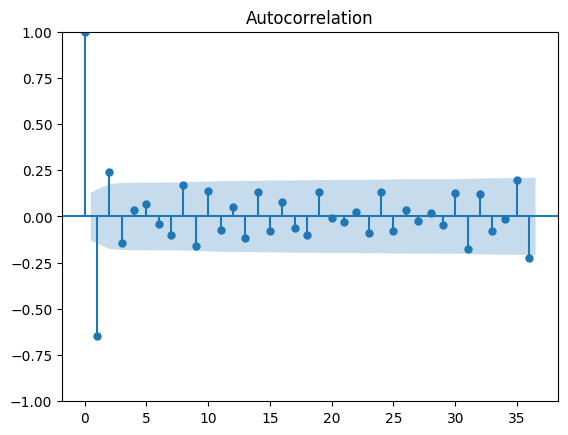

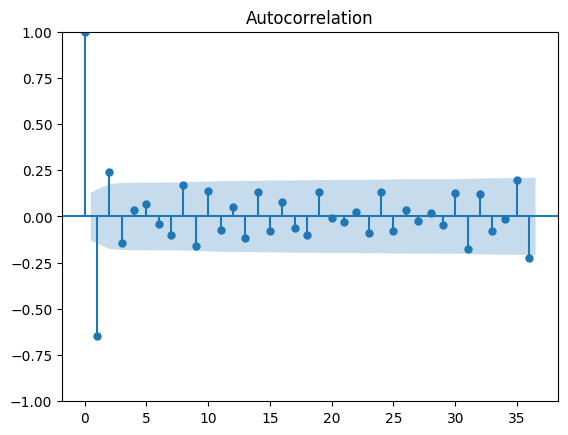

In [134]:
plot_acf(importacion_regular_train1, lags=36)

Se crearán dos modelos de ARIMA con parámetros: 
* p = 2, d = 1, q = 1
* p = 2, d = 1, q = 2

In [150]:
# modelo1 = sm.tsa.ARIMA(importacion_regular_train, order=(2, 1, 1))
# resultado_m1 = modelo1.fit()
# print(resultado_m1.summary().tables[1])

modelo1 = SARIMAX(importacion_regular_train, order=(2,1,1), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m1 = modelo1.fit()
print(resultado_m1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3331      0.154     -2.165      0.030      -0.635      -0.032
ar.L2          0.0347      0.140      0.248      0.804      -0.239       0.309
ma.L1         -0.8459      0.074    -11.487      0.000      -0.990      -0.702
ar.S.L12      -0.5681      0.095     -6.005      0.000      -0.754      -0.383
sigma2      1.388e+10   1.91e-12   7.28e+21      0.000    1.39e+10    1.39e+10


In [151]:
modelo2 = SARIMAX(importacion_regular_train, order=(2,1,2), seasonal_order=(1,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m2 = modelo2.fit()
print(resultado_m2.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7397      1.760     -0.420      0.674      -4.189       2.710
ar.L2         -0.0904      0.677     -0.133      0.894      -1.418       1.237
ma.L1         -0.4321      1.767     -0.244      0.807      -3.896       3.032
ma.L2         -0.3519      1.447     -0.243      0.808      -3.188       2.484
ar.S.L12      -0.5679      0.084     -6.756      0.000      -0.733      -0.403
sigma2      1.234e+10   8.86e-10   1.39e+19      0.000    1.23e+10    1.23e+10


### g. Haga varios modelos ARIMA, y diga cuál es el mejor de ellos para estimar los datos de la serie. Para esto analice los residuos y las métricas AIC y/ BIC.
Los modelos se habían hecho previamente.

#### Modelo 1

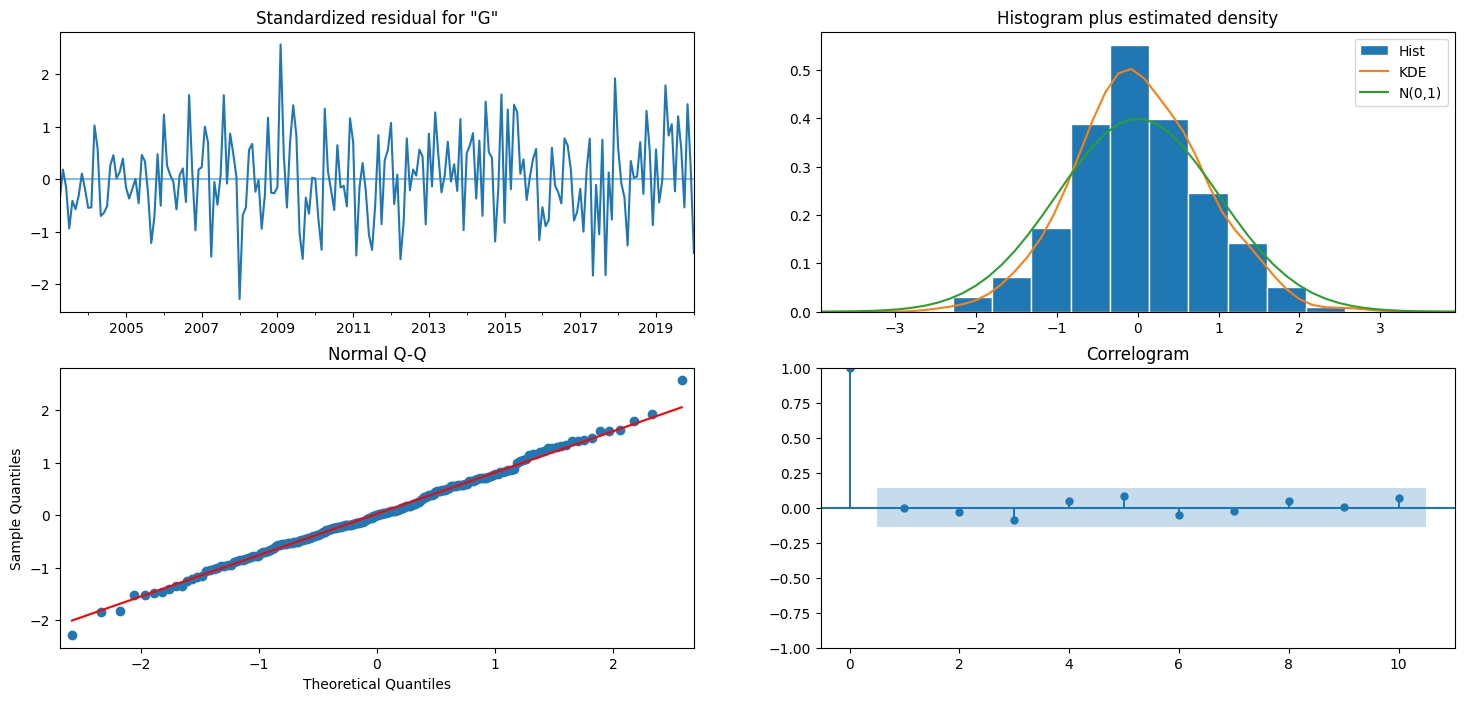

In [152]:
resultado_m1.plot_diagnostics(figsize=(18, 8))
plt.show()

#### Modelo 2

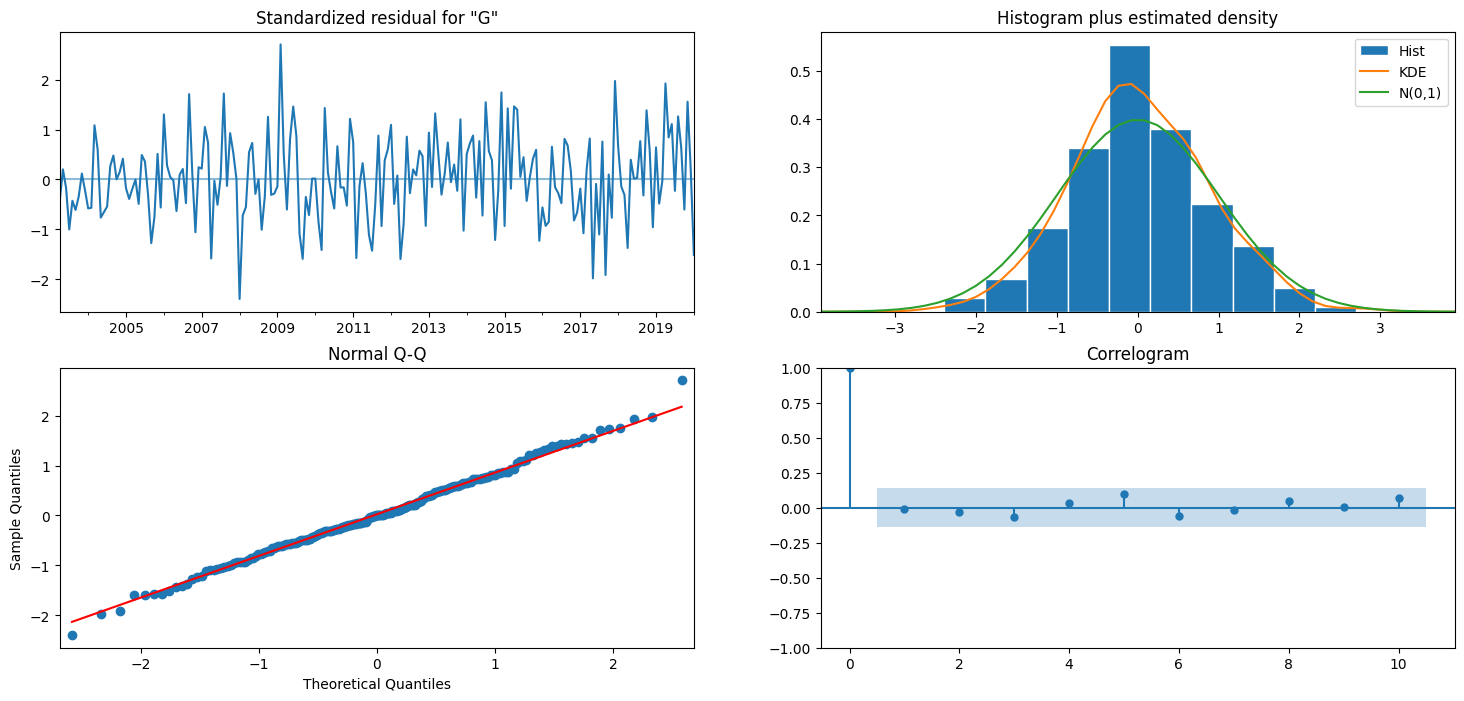

In [153]:
resultado_m2.plot_diagnostics(figsize=(18, 8))
plt.show()

Al observar el análisis de residuales de ambos modelos se puede evidenciar que es posible que los residuales solo sean ruido blanco. Se ve una distribución normal, a excepción por unos puntos atípicos en las colas. Además, no se ve correlación entre los puntos, al ver el correlograma.

In [154]:
print("AIC para modelo 1:", resultado_m1.aic)
print("BIC para modelo 1:", resultado_m1.bic)
print("\nAIC para modelo 2:", resultado_m2.aic)
print("BIC para modelo 2:", resultado_m2.bic)

AIC para modelo 1: 5224.08094427463
BIC para modelo 1: 5240.622282761637

AIC para modelo 2: 5217.691567789766
BIC para modelo 2: 5237.541173974173


Se puede observar que ambos modelos tienen residuales muy similares. Además, al comparar el AIC y el BIC de ambos modelos, ambos son bastante similares. El segundo modelo tiene un AIC un poco más bajo que el segundo modelo, igual en BIC. Entonces es posible decir que el segundo modelo es mejor.
En general, para ambos modelos el AIC y BIC son bastante altos, por lo que probablemente no sean buenos modelo.

#### h. Haga un modelo usando el algoritmo de redes neuronales. Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?

In [164]:
# En esta ocasion solo usaremos train y test, validation lo omitiremos para simpleza del ejercicio
# NO CAMBIEN NADA DE ESTA CELDA POR FAVOR
p_train=0.8
p_test=0.2

datos = importacion_regular_train1[['Gasolina regular']].values.astype('float32')

# Definimos el tamaño de las particiones
num_train = int(len(datos)*p_train)
num_test = int(len(datos)*p_test)


# Dividir las secuencias en las particiones
train = datos[:num_train]
test = datos[num_train:]

In [165]:
import torch

def create_timeseries_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

# EL VALOR DE LB SÍ LO PUEDEN CAMBIAR SI LO CONSIDERAN NECESARIO
lb = 5
X_train, y_train = create_timeseries_dataset(train, lookback=lb)
#X_validation, y_validation = create_timeseries_dataset(validation, lookback=lb)
X_test, y_test = create_timeseries_dataset(test, lookback=lb)

print(X_train.shape, y_train.shape)
#print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

torch.Size([177, 5, 1]) torch.Size([177, 5, 1])
torch.Size([41, 5, 1]) torch.Size([41, 5, 1])


In [167]:
import torch.nn as nn

class CustomModelLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1 , hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        # YOUR CODE HERE
        x, _ = self.lstm(x)
        x = self.linear(x)
        # raise NotImplementedError()
        return x

In [168]:
import torch.optim as optim
import torch.utils.data as data
import random
seed_ = 1234
# NOTEN QUE ESTOY PONIENDO DE NUEVO LOS SEEDS PARA SER CONSTANTES
random.seed(seed_)
np.random.seed(seed_)
 
model = CustomModelLSTM()
# Optimizador y perdida
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# Observen como podemos también definir un DataLoader de forma snecilla
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)
 
# Pueden cambiar el número de epocas en esta ocasión con tal de llegar al valor de la metrica de desempeño
n_epochs = 3010

# Perdidas
loss_train = []
loss_test = []

# Iteramos sobre cada epoca
for epoch in range(n_epochs):
    # Colocamos el modelo en modo de entrenamiento
    model.train()
    
    # Cargamos los batches
    for X_batch, y_batch in loader:
        # Obtenemos una primera prediccion
        y_pred = model(X_batch)
        # Calculamos la perdida
        loss = loss_fn(y_pred, y_batch)
        # Reseteamos la gradiente a cero
        #   sino la gradiente de previas iteraciones se acumulará con las nuevas
        optimizer.zero_grad()
        # Backprop
        loss.backward()
        # Aplicar las gradientes para actualizar los parametros del modelo
        optimizer.step()
        
    # Validación cada 100 epocas
    if epoch % 100 != 0 and epoch != n_epochs-1:
        continue
    # Colocamos el modelo en modo de evaluación
    model.eval()
    
    # Deshabilitamos el calculo de gradientes
    with torch.no_grad():
        # Prediccion
        y_pred = model(X_train)
        # Calculo del RMSE - Root Mean Square Error
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        # Prediccion sobre validation
        y_pred = model(X_test)
        # Calculo del RMSE para validation
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        loss_train.append(train_rmse)
        loss_test.append(test_rmse)
        
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 0.0901, test RMSE 0.0603
Epoch 100: train RMSE 0.0602, test RMSE 0.0318
Epoch 200: train RMSE 0.0617, test RMSE 0.0326
Epoch 300: train RMSE 0.0596, test RMSE 0.0332
Epoch 400: train RMSE 0.0591, test RMSE 0.0333
Epoch 500: train RMSE 0.0587, test RMSE 0.0334
Epoch 600: train RMSE 0.0582, test RMSE 0.0334
Epoch 700: train RMSE 0.0575, test RMSE 0.0336
Epoch 800: train RMSE 0.0567, test RMSE 0.0340
Epoch 900: train RMSE 0.0555, test RMSE 0.0345
Epoch 1000: train RMSE 0.0546, test RMSE 0.0351
Epoch 1100: train RMSE 0.0538, test RMSE 0.0360
Epoch 1200: train RMSE 0.0532, test RMSE 0.0371
Epoch 1300: train RMSE 0.0525, test RMSE 0.0381
Epoch 1400: train RMSE 0.0515, test RMSE 0.0397
Epoch 1500: train RMSE 0.0505, test RMSE 0.0424
Epoch 1600: train RMSE 0.0497, test RMSE 0.0456
Epoch 1700: train RMSE 0.0490, test RMSE 0.0458
Epoch 1800: train RMSE 0.0484, test RMSE 0.0458
Epoch 1900: train RMSE 0.0484, test RMSE 0.0477
Epoch 2000: train RMSE 0.0475, test RMSE 0.0480
Epoc

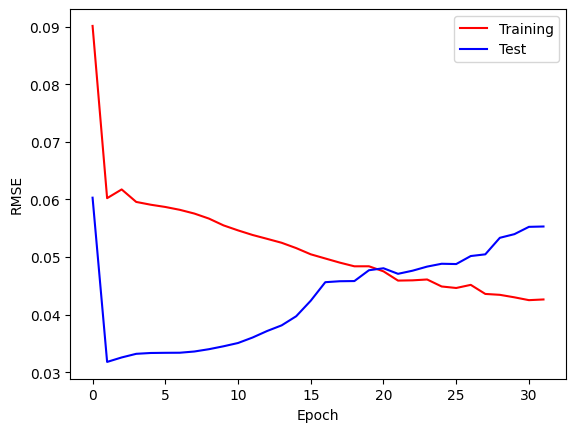

In [169]:
# Visualización del rendimiento
epoch = np.arange(len(loss_train))
plt.figure()
plt.plot(epoch, loss_train, 'r', label='Training',)
plt.plot(epoch, loss_test, 'b', label='Test')
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('RMSE')
plt.show()

Se puede observar que la pérdida para train y test es muy diferente, por lo tanto es posible que sea un mal modelo.

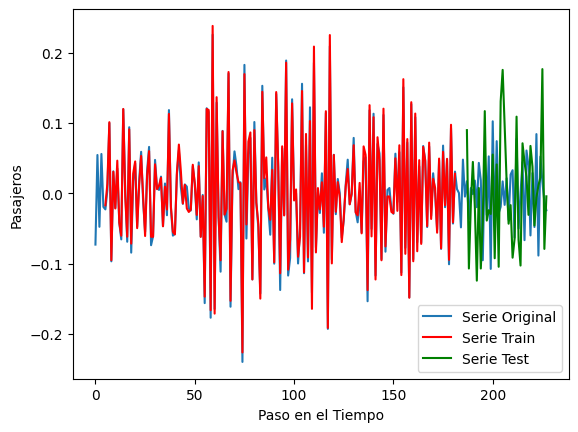

In [170]:
# Graficamos
with torch.no_grad():
    # Movemos las predicciones de train para graficar
    train_plot = np.ones_like(datos) * np.nan
    # Prediccion de train
    y_pred = model(X_train)
    # Extraemos los datos solo del ultimo paso
    y_pred = y_pred[:, -1, :]
    train_plot[lb : num_train] = model(X_train)[:, -1, :]
    # Movemos las predicciones de test
    test_plot = np.ones_like(datos) * np.nan
    test_plot[num_train + lb : len(datos)] = model(X_test)[:, -1, :]
    
plt.figure()
plt.plot(datos, label="Serie Original")
plt.plot(train_plot, c='r', label="Serie Train")
plt.plot(test_plot, c='g', label="Serie Test")
plt.xlabel('Paso en el Tiempo'), plt.ylabel('Pasajeros')
plt.legend()
plt.show()

In [171]:
y_pred = model(X_test)
residuals = y_pred - y_test
# Calculate log-likelihood of residuals
log_likelihood = -0.5 * torch.sum(torch.log(2 * np.pi * torch.var(residuals)) + (residuals ** 2) / torch.var(residuals))

# Calculate the number of parameters in your model
num_params = sum(p.numel() for p in model.parameters())

# Calculate the number of samples
num_samples = len(y_pred)

# Calculate AIC and BIC
AIC = 2 * num_params - 2 * log_likelihood
BIC = num_params * np.log(num_samples) - 2 * log_likelihood

print("AIC:", AIC)
print("BIC:", BIC)

AIC: tensor(20696.7949, grad_fn=<RsubBackward1>)
BIC: tensor(38948.0547, grad_fn=<RsubBackward1>)


Se puede observar que al usar LSTM para realizar la predicción de serie de tiempo, el AIC y BIC tiene valores demasiado altos, de 20696.79 y 38948.0547 respectivamente. Por lo tanto, no es un buen modelo para realizar la predicción del dataset.

## 4. Haga una predicción de los valores de la serie para los últimos 3 años. Explique qué tan buena es su predicción. En el caso de la serie de precios, use los datos de 2023 como conjunto de prueba

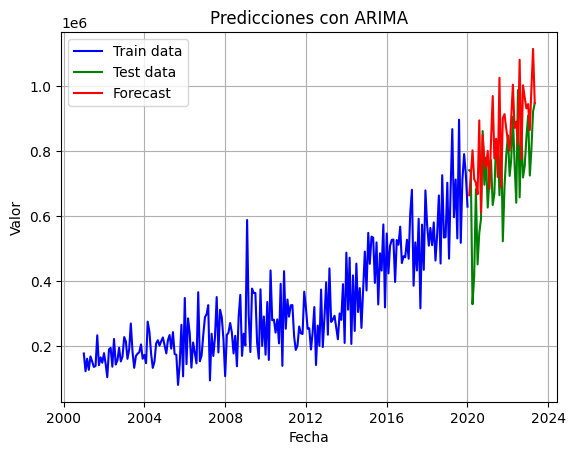

In [172]:
model_fit = modelo1.fit()
forecast = model_fit.predict(start=importacion_regular_test.index[0], end=importacion_regular_test.index[-1], dynamic=True)
forecasted = np.cumsum(np.concatenate(([importacion_regular_train["Gasolina regular"].iloc[-1]], forecast)))
forecasted = forecasted[1:]
plt.plot(importacion_regular_train.index, (importacion_regular_train['Gasolina regular']), label='Train data', color='blue')
plt.plot(importacion_regular_test.index, importacion_regular_test['Gasolina regular'], label='Test data', color='green')
plt.plot(importacion_regular_test.index, forecast, label='Forecast', color='red')

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones con ARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [173]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convierte las predicciones a un array numpy
predicciones_array = forecast

# Calcula el MAE (Error Absoluto Medio)
mae = mean_absolute_error(importacion_regular_test["Gasolina regular"], predicciones_array)

# Calcula el MSE (Error Cuadrático Medio)
mse = mean_squared_error(importacion_regular_test["Gasolina regular"], predicciones_array)

# Calcula el RMSE (Raíz del Error Cuadrático Medio)
rmse = np.sqrt(mse)

# Calcula el MAPE (Error Porcentual Absoluto Medio)
mape = np.mean(np.abs((importacion_regular_test["Gasolina regular"] - predicciones_array) / importacion_regular_test["Gasolina regular"])) * 100

print("mae:", mae)
print("mse:", mse)
print("rmse:", rmse)
print("mape:", mape)

mae: 152703.37120491517
mse: 39197952052.401764
rmse: 197984.72681598892
mape: 25.0633837906896


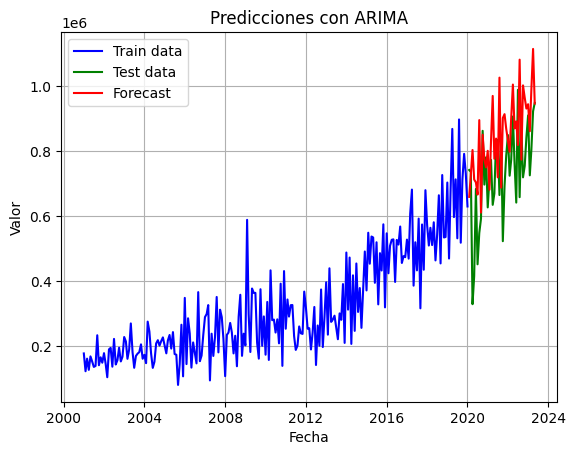

In [174]:
model_fit = modelo2.fit()
forecast = model_fit.predict(start=importacion_regular_test.index[0], end=importacion_regular_test.index[-1], dynamic=True)
forecasted = np.cumsum(np.concatenate(([importacion_regular_train["Gasolina regular"].iloc[-1]], forecast)))
forecasted = forecasted[1:]
plt.plot(importacion_regular_train.index, (importacion_regular_train['Gasolina regular']), label='Train data', color='blue')
plt.plot(importacion_regular_test.index, importacion_regular_test['Gasolina regular'], label='Test data', color='green')
plt.plot(importacion_regular_test.index, forecast, label='Forecast', color='red')

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones con ARIMA')
plt.legend()
plt.grid(True)
plt.show()

In [175]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Convierte las predicciones a un array numpy
predicciones_array = forecast

# Calcula el MAE (Error Absoluto Medio)
mae = mean_absolute_error(importacion_regular_test["Gasolina regular"], predicciones_array)

# Calcula el MSE (Error Cuadrático Medio)
mse = mean_squared_error(importacion_regular_test["Gasolina regular"], predicciones_array)

# Calcula el RMSE (Raíz del Error Cuadrático Medio)
rmse = np.sqrt(mse)

# Calcula el MAPE (Error Porcentual Absoluto Medio)
mape = np.mean(np.abs((importacion_regular_test["Gasolina regular"] - predicciones_array) / importacion_regular_test["Gasolina regular"])) * 100

print("mae:", mae)
print("mse:", mse)
print("rmse:", rmse)
print("mape:", mape)

mae: 152440.72920994175
mse: 39064662117.75871
rmse: 197647.82345818714
mape: 25.014290091960557


Como se puede observar en las métricas de rendimiento, los valores son demasiado altos. Esto indica que los modelos no son buenos para realizar las predicciones. En términos de métricas de rendimiento, el segundo modelo es mejor que el primero para predecir el consumo de diesel.

### 5. Haga una predicción para todo este año 2023 determine qué tan apegada es a la realidad teniendo en cuenta los meses pasados del año actual.

[944933.0, 864814.0, 988647.0, 1114498.0, 947990.0, 990844.0, 893279.0, 1179552.0, 855549.0, 1075238.0, 1065836.0, 1025810.0]
Fecha
2023-01-01    909391.13
2023-02-01    725101.20
2023-03-01    803262.67
2023-04-01    922032.39
2023-05-01    947633.29
Name: Gasolina regular, dtype: float64
Fecha
2023-01-01    -35541.87
2023-02-01   -139712.80
2023-03-01   -185384.33
2023-04-01   -192465.61
2023-05-01      -356.71
Name: Gasolina regular, dtype: float64


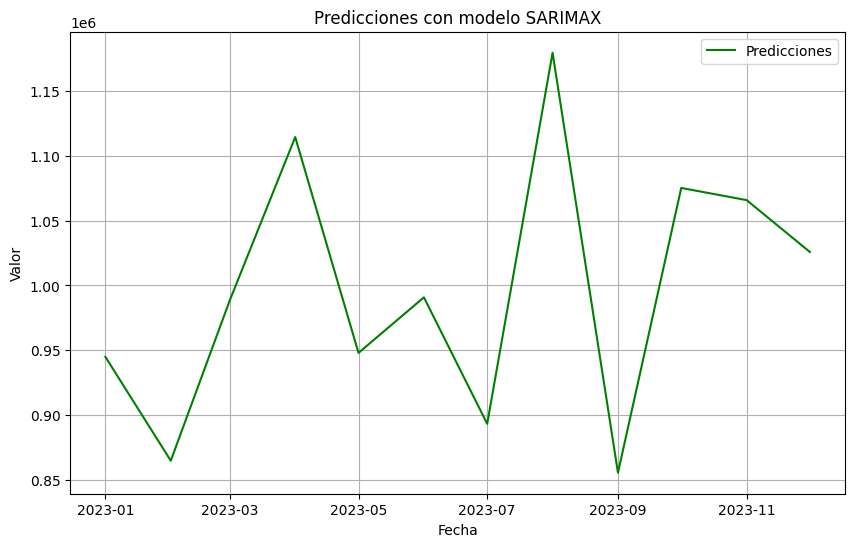

In [177]:
predicciones = resultado_m1.get_prediction(start='2023-01-01', end='2023-12-01', dynamic=False)
predicciones_valores = predicciones.predicted_mean
print([float("{:.0f}".format(valor)) for valor in predicciones_valores])
print(importacion_regular[importacion_regular.index.year == 2023]["Gasolina regular"])
print(importacion_regular[importacion_regular.index.year == 2023]["Gasolina regular"] - [float("{:.0f}".format(valor)) for valor in predicciones_valores][0:5])
intervalos_confianza = predicciones.conf_int()
plt.figure(figsize=(10, 6))
plt.plot(predicciones_valores.index, predicciones_valores, label='Predicciones', color='green')

plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones con modelo SARIMAX')
plt.legend()
plt.grid(True)
plt.show()

Al comparar los valores predichos por la serie de tiempo y los verdaderos que se han dado en los primeros meses de 2023, podemos observar que no existe una diferencia muy grande. Sin embargo, la diferencia está en el orden de los cientos de miles consumidos para algunos meses, por lo que el modelo no es muy bueno.

### 6. Discuta cuál fue el comportamiento de las series durante la pandemia. ¿Qué tanto afectó las predicciones? ¿se recuperaron los valores habituales en el regreso a la “nueva normalidad”?

La importación de diesel, gasolina superior y gasolina regular se puede observar un comportamiento muy similar durante la pandemia. En general se ve que conforme pasan los años, aumenta la importación de combustible. En 2020 se ve una reducción en esa importación, esto es muy probable que se deba a las restricciones de importación de la pandemia. Sin embargo, en 2021 y en 2022 se dan los valores más altos de consumo históricos, esto influenciado por la necesidad de adquisición de combustibles por la falta de ellos durante la cuarentena. A pesar de esto, los valores de importación no fueron tan atípicos, si no que pareciera que seguían la tendencia previa. Entonces es posible que no haya sido esto lo que afectó las predicciones.